In [1]:
import matplotlib.pyplot as plt
import scienceplots
scienceplots.stylesheets
plt.style.use('science')

# Read Data

In [2]:
from dataset import *
SEED_NUMBER = 1

raw_datasets = prepare_dataset(feature_type='raw_normalized', class_type='binary', overlap_percent=0)
raw_trainloaders, raw_valloaders, raw_testloaders = prepare_dataloaders(raw_datasets, 1, 0.2, SEED_NUMBER, with_subject_id=True)

deap_raw, seed_raw, dreamer_raw = raw_testloaders
raw_dict = {
    'DEAP': deap_raw,
    'SEED': seed_raw,
    'DREAMER': dreamer_raw
}

grid_datasets = prepare_dataset(feature_type='de_grid', class_type='binary', overlap_percent=0)
grid_trainloaders, grid_valloaders, grid_testloaders = prepare_dataloaders(grid_datasets, 1, 0.2, SEED_NUMBER, with_subject_id=True)

deap_grid, seed_grid, dreamer_grid = grid_testloaders
grid_dict = {
    'DEAP': deap_grid,
    'SEED': seed_grid,
    'DREAMER': dreamer_grid
}

[2024-08-01 14:04:01] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_raw_normalized_0_percent_overlap.
[2024-08-01 14:04:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/seed_binary_raw_normalized_0_percent_overlap.
[2024-08-01 14:04:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/dreamer_raw_normalized_0_percent_overlap.
[2024-08-01 14:04:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_de_grid_0_percent_overlap.
[2024-08-01 14:04:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/seed_binary_de_grid_0_percent_overlap.
[2024-08-01 14:04:02] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/dreamer_de_grid_0_percent_overlap.


# Temporal Representation (Raw Visualization)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eeg_channels(dataset_name, eeg_stimuli, name_list, plot_title, save_path=None):
    n_channels = eeg_stimuli.shape[0]

    # Create a new figure with subplots
    fig, axes = plt.subplots(n_channels, 1, figsize=(5, int(n_channels//3)))

    # Loop over all axes (for EEG channels)
    for i in range(n_channels):
        # Plot each EEG channel in its own row
        axes[i].plot(eeg_stimuli[i, :], color='black')
        
        # Set y-axis label to the left of the subplot as the title
        axes[i].set_ylabel(name_list[i], rotation=0, labelpad=5, verticalalignment='center', horizontalalignment='right')

        # Hide the y-ticks
        axes[i].set_yticks([])

        # Hide the box (spines) around the subplot
        for spine in axes[i].spines.values():
            spine.set_visible(False)

        # Ensure no grid lines are displayed
        axes[i].grid(False)
        
        # Set the x-axis limit to start at 0
        axes[i].set_xlim(left=0)
        
        # Hide x-ticks and labels for all but the last subplot
        if i < n_channels - 1:
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        else:
            # For the last subplot, remove top x-ticks and minor x-ticks
            axes[i].tick_params(axis='x', which='minor', top=False)
            axes[i].tick_params(axis='x', which='major', top=False)

    # Set x-axis ticks for the last subplot, for every 0.25 seconds
    sampling_rate = 200 if dataset_name == 'SEED' else 128
    ticks = np.arange(0, eeg_stimuli.shape[-1]+1, 0.25*sampling_rate)  # seconds * sampling rate
    tick_labels = [str(round(tick / sampling_rate, 2)) for tick in ticks]  # Convert sample indices back to seconds
    axes[-1].set_xticks(ticks)
    axes[-1].set_xticklabels(tick_labels)

    # Set the x-axis label for the last subplot
    axes[-1].set_xlabel('Time (s)')

    # Title
    axes[0].set_title(plot_title, fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # Save
    if save_path:
        fig.savefig(save_path, dpi=300)

    # Display the figure
    plt.show()

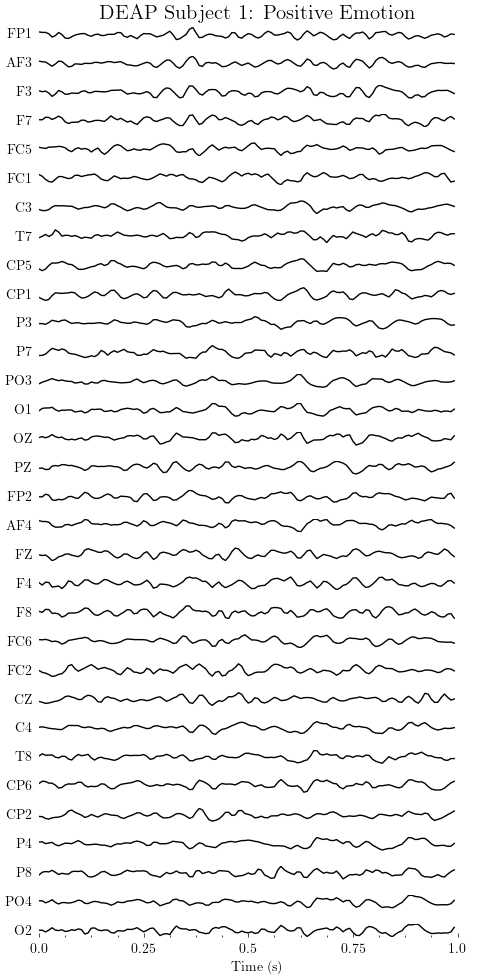

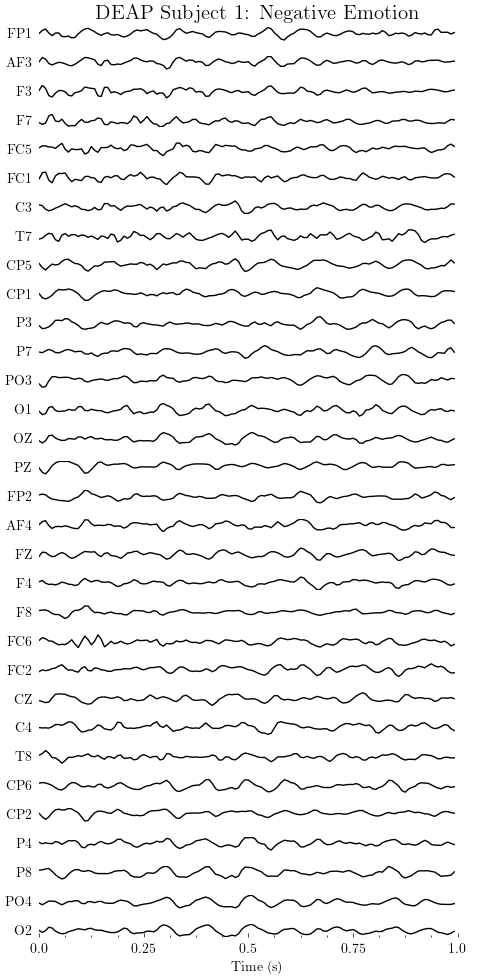

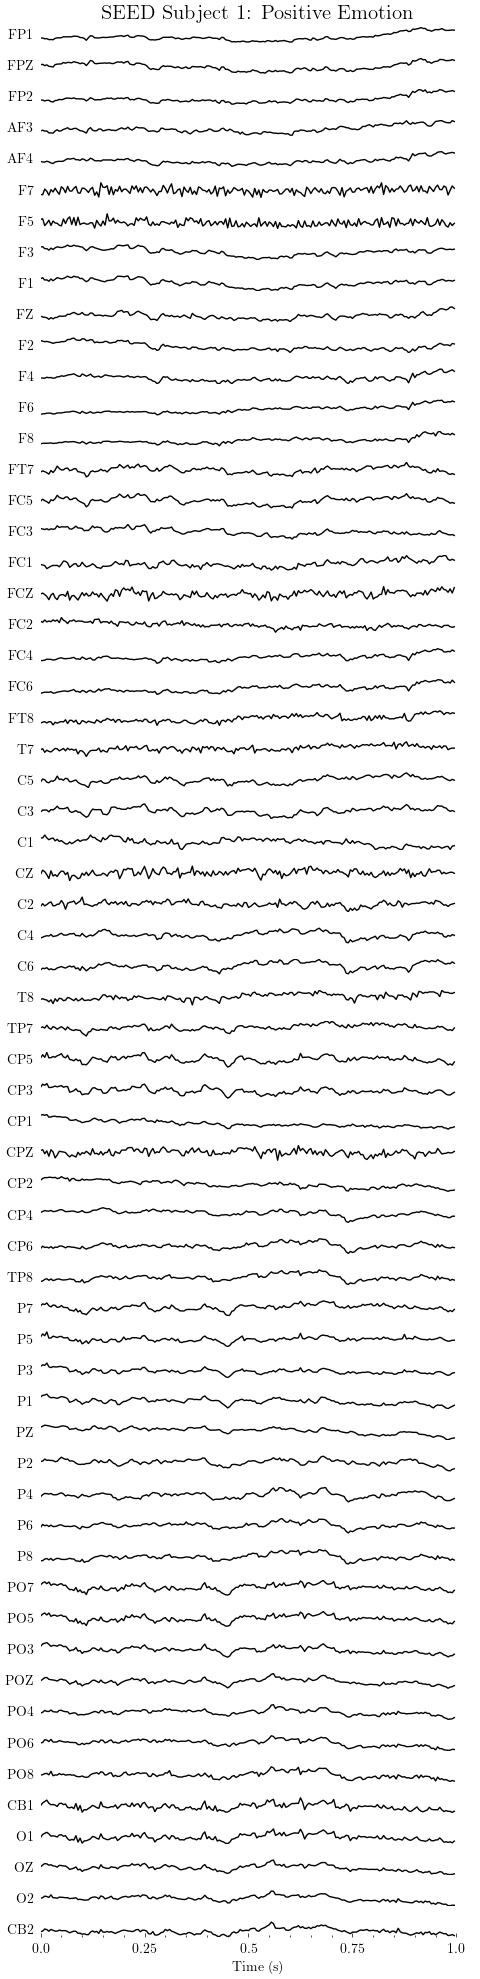

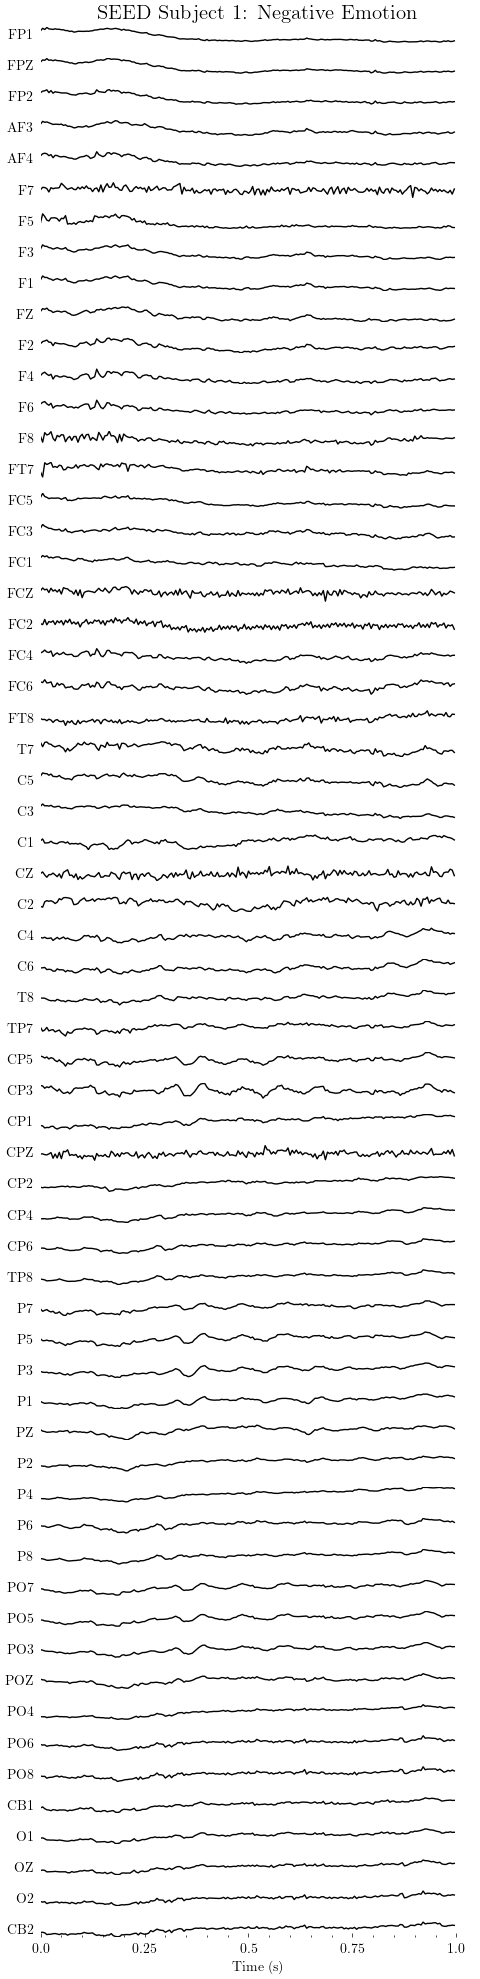

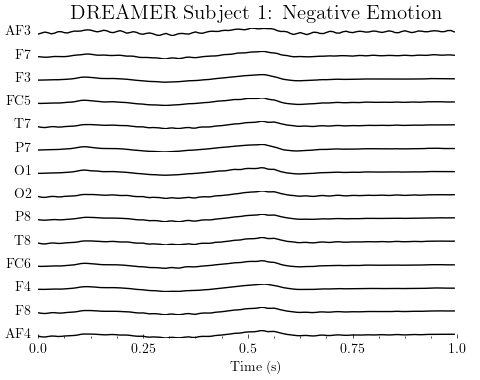

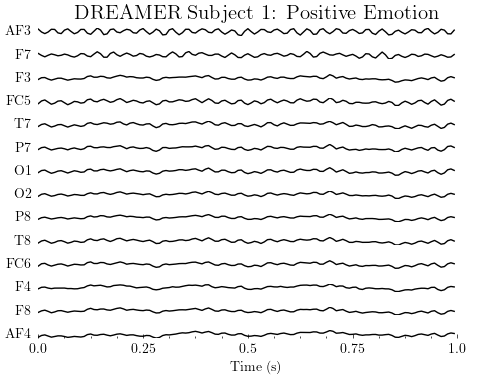

In [4]:
from torcheeg.datasets.constants.emotion_recognition.deap import DEAP_CHANNEL_LIST
from torcheeg.datasets.constants.emotion_recognition.seed import SEED_CHANNEL_LIST
from torcheeg.datasets.constants.emotion_recognition.dreamer import DREAMER_CHANNEL_LIST

for dataset_name, loader in raw_dict.items():
    # Counts for each dataset
    positive_count = 0
    negative_count = 0
    
    for i, (X, y, subject_id) in enumerate(loader):
        subject_id = subject_id[0]
        if dataset_name == 'DEAP':
            subject_id = int(subject_id[1:3])
            name_list = DEAP_CHANNEL_LIST
        elif dataset_name == 'DREAMER':
            subject_id = int(subject_id + 1)
            name_list = DREAMER_CHANNEL_LIST
        else:
            subject_id = int(subject_id)
            name_list = SEED_CHANNEL_LIST
            
        if subject_id != 1:
            continue
        
        emotion = 'Positive' if y[0] == 1 else 'Negative'
        
        # Check if the emotion count is already fulfilled
        if emotion == 'Positive' and positive_count >= 1:
            continue
        elif emotion == 'Negative' and negative_count >= 1:
            continue

        # plotting function
        title = f"{dataset_name} Subject {subject_id}: {emotion} Emotion"
        save_path = f"figures/raw/{dataset_name.lower()}_{subject_id}_{emotion.lower()}.png"
        
        plot_eeg_channels(dataset_name, X[0], name_list, plot_title=title, save_path=save_path)
        
        # Increment the corresponding counter
        if emotion == 'Positive':
            positive_count += 1
        elif emotion == 'Negative':
            negative_count += 1
        
        # Break if both positive and negative emotions have been visualized
        if positive_count >= 1 and negative_count >= 1:
            break

# Spatial Representation (Grid Visualization)

In [5]:
head_outline = plt.imread('figures/head_outline_transparent.png')

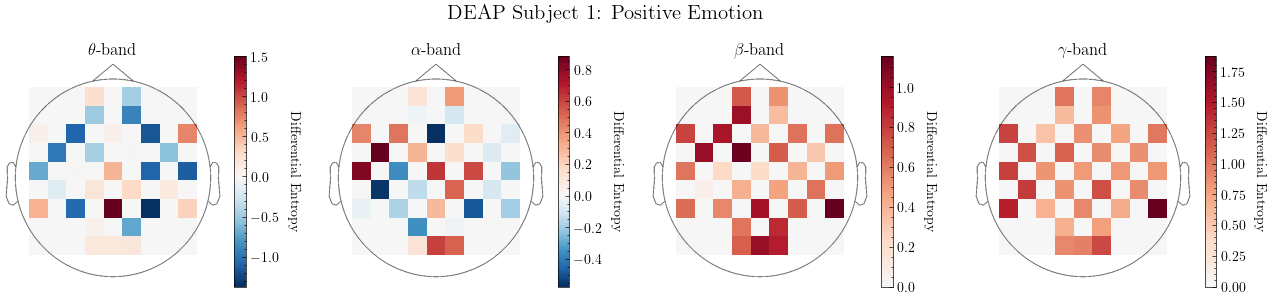

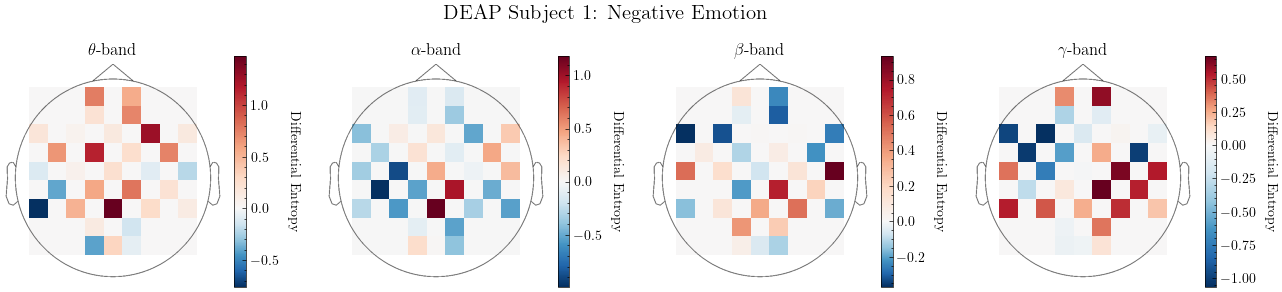

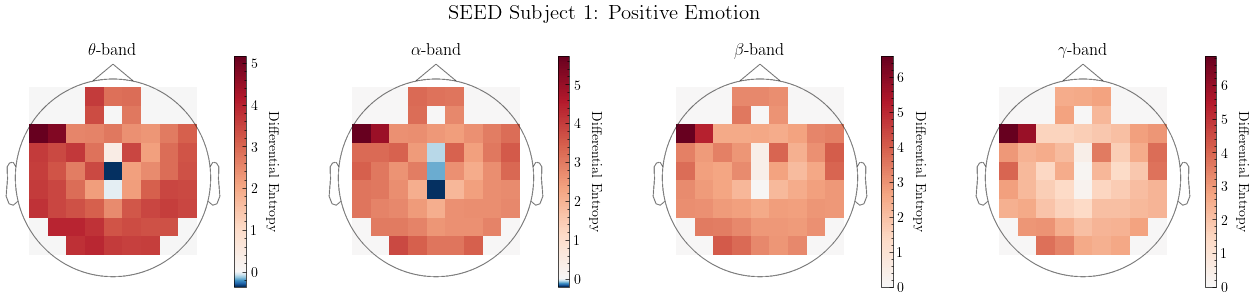

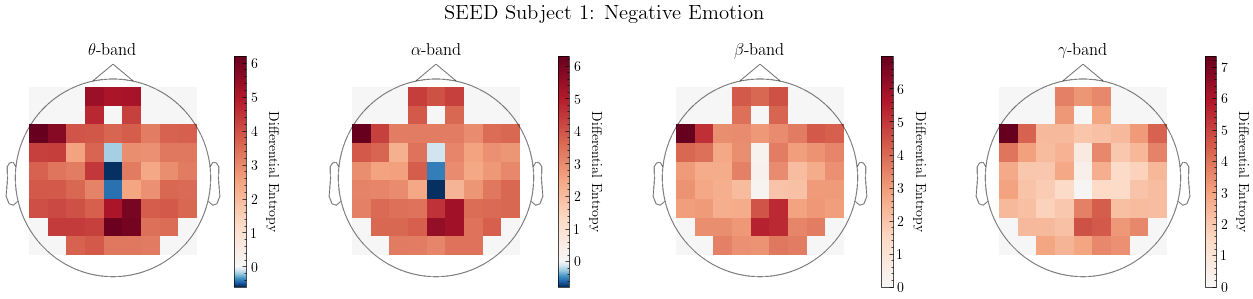

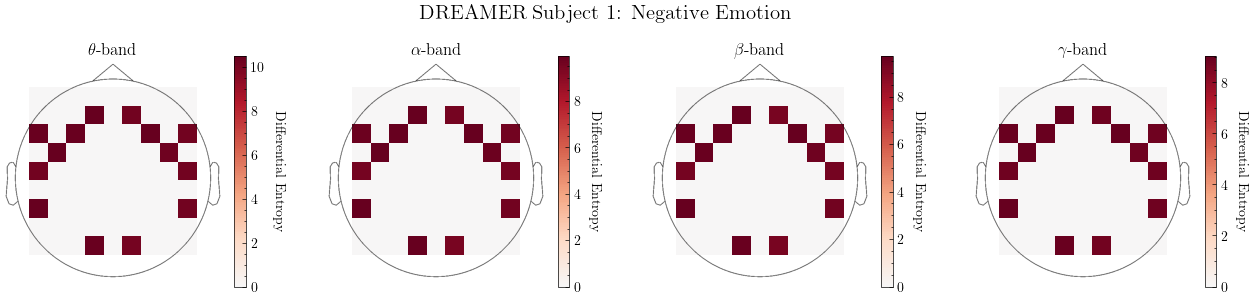

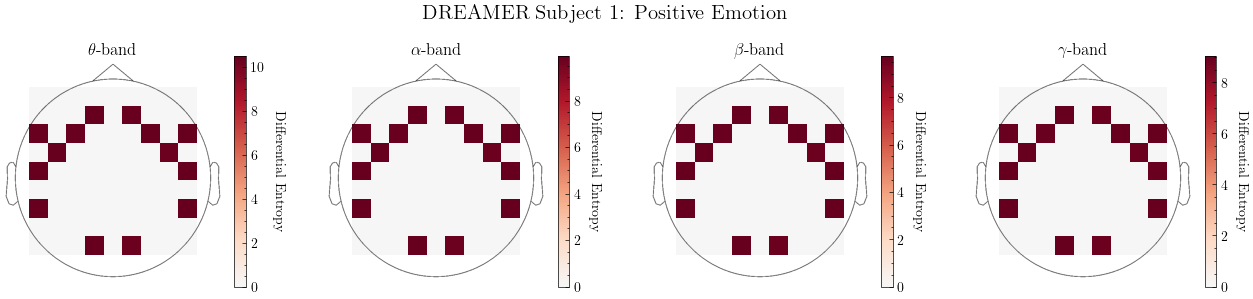

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import warnings

import torch
torch.multiprocessing.set_sharing_strategy('file_system')

bands = ['$\\theta$-band', '$\\alpha$-band', '$\\beta$-band', '$\\gamma$-band']
warnings.filterwarnings("ignore", category=DeprecationWarning)

for dataset_name, loader in grid_dict.items():
    # Reset counts for each dataset
    positive_count = 0
    negative_count = 0
    
    for i, (X, y, subject_id) in enumerate(loader):
        subject_id = subject_id[0]
        if dataset_name == 'DEAP':
            subject_id = int(subject_id[1:3])
        elif dataset_name == 'DREAMER':
            subject_id = int(subject_id + 1)
        else:
            subject_id = int(subject_id)
            
        if subject_id != 1:
            continue
        
        emotion = 'Positive' if y[0] == 1 else 'Negative'
        
        # Check if the emotion count is already fulfilled
        if emotion == 'Positive' and positive_count >= 1:
            continue
        elif emotion == 'Negative' and negative_count >= 1:
            continue
        
        grid = X[0]
        fig, axes = plt.subplots(1, 4, figsize=(16, 3))
        for j, ax in enumerate(axes):
            vmin = grid[j].min()
            vmax = grid[j].max()
            vcenter = 0
            
            # Adjust vcenter to be within vmin and vmax range
            if vcenter < vmin:
                vcenter = vmin
            if vcenter > vmax:
                vcenter = vmax
            
            # Plot the background image
            ax.imshow(head_outline, aspect='auto', extent=[0, 9, 9, 0], alpha=1, zorder=3)
            
            # Plot the heatmap with a smaller extent
            norm = TwoSlopeNorm(vmin=vmin-1e-10, vcenter=vcenter, vmax=vmax+1e-10)
            h = sns.heatmap(grid[j], norm=norm, cmap="RdBu_r", cbar=False, ax=ax, alpha=0, zorder=2)
            ax.set_title(bands[j])
            ax.axis('off')
            
            # Shrink the heatmap to be smaller within the same background extent
            im = ax.imshow(grid[j], extent=[1, 8, 8, 1], alpha=1, zorder=1, cmap="RdBu_r", norm=norm)
            
            # Create the colorbar
            cbar = fig.colorbar(im, ax=ax)
            cbar.ax.set_yscale('linear')
            cbar.set_label('Differential Entropy', rotation=270, labelpad=15)
            
            
        plt.suptitle(f"{dataset_name} Subject {subject_id}: {emotion} Emotion", y=1.05, fontsize=15)
        plt.savefig(f"figures/grid/{dataset_name.lower()}_{subject_id}_{emotion.lower()}.png", dpi=500)
        plt.show()
        
        # Increment the corresponding counter
        if emotion == 'Positive':
            positive_count += 1
        elif emotion == 'Negative':
            negative_count += 1
        
        # Break if both positive and negative emotions have been visualized
        if positive_count >= 1 and negative_count >= 1:
            break

# Combine png

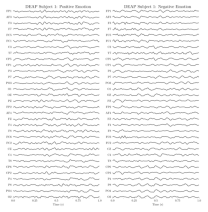

Combined image saved as figures/raw/deap_1_combined.png


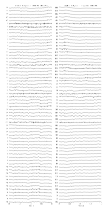

Combined image saved as figures/raw/seed_1_combined.png


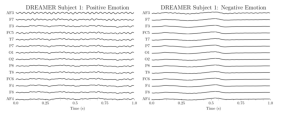

Combined image saved as figures/raw/dreamer_1_combined.png


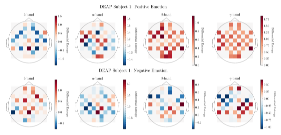

Combined image saved as figures/grid/deap_1_combined.png


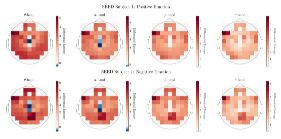

Combined image saved as figures/grid/seed_1_combined.png


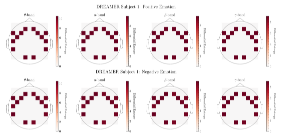

Combined image saved as figures/grid/dreamer_1_combined.png


In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def plot_and_save_images(image_paths, orientation='horizontal'):
    # Load the images
    images = [Image.open(image_path) for image_path in image_paths]

    # Determine the layout based on the orientation
    num_images = len(images)
    if orientation == 'horizontal':
        widths, heights = zip(*(i.size for i in images))
        total_width = sum(widths)
        max_height = max(heights)
        combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))  # white background
        x_offset = 0
        for im in images:
            combined_image.paste(im, (x_offset, 0))
            x_offset += im.width
    elif orientation == 'vertical':
        widths, heights = zip(*(i.size for i in images))
        max_width = max(widths)
        total_height = sum(heights)
        combined_image = Image.new('RGB', (max_width, total_height), (255, 255, 255))  # white background
        y_offset = 0
        for im in images:
            combined_image.paste(im, (0, y_offset))
            y_offset += im.height
    else:
        raise ValueError("Orientation must be 'horizontal' or 'vertical'")

    # Display the plot
    plt.imshow(combined_image)
    plt.axis('off')  # Hide the axis
    plt.show()

    # Generate the combined image filename
    dir_name = os.path.dirname(image_paths[0])
    base_name = os.path.commonprefix([os.path.basename(path).rsplit('.', 1)[0] for path in image_paths]).rstrip('_')
    combined_image_path = os.path.join(dir_name, f"{base_name}_combined.png")

    # Save the combined image
    combined_image.save(combined_image_path, dpi=(300, 300))
    print(f'Combined image saved as {combined_image_path}')

# Usage
image_paths = {
    'horizontal': [
        ['figures/raw/deap_1_positive.png', 'figures/raw/deap_1_negative.png'],
        ['figures/raw/seed_1_positive.png', 'figures/raw/seed_1_negative.png'],
        ['figures/raw/dreamer_1_positive.png', 'figures/raw/dreamer_1_negative.png'],
    ],
    'vertical': [
        ['figures/grid/deap_1_positive.png', 'figures/grid/deap_1_negative.png'],
        ['figures/grid/seed_1_positive.png', 'figures/grid/seed_1_negative.png'],
        ['figures/grid/dreamer_1_positive.png', 'figures/grid/dreamer_1_negative.png'],
    ]
}

for orientation, paths in image_paths.items():
    for path in paths:
        plot_and_save_images(path, orientation)

# Embedding Representation

In [8]:
SEED_NUMBER = 1

In [9]:
import torch
import numpy as np
from dataset import *

def load_raw_data(dataset_name):
    raw_datasets = prepare_dataset(feature_type='raw_normalized', class_type='binary', overlap_percent=0)
    raw_trainloaders, raw_valloaders, raw_testloaders = prepare_dataloaders(raw_datasets, 64, 0.2, SEED_NUMBER)
    
    deap, seed, dreamer = raw_testloaders
    
    if dataset_name == "DEAP":
        return deap
    elif dataset_name == "SEED":
        return seed
    elif dataset_name == "DREAMER":
        return dreamer

In [10]:
from torcheeg.trainers import ClassifierTrainer

def load_client_model(dataset_name):
    client_models_folder = f"models/client/seed_number_{SEED_NUMBER}"
    checkpoint_path = f'{client_models_folder}/{dataset_name}.ckpt'
    
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    hparams = checkpoint['hyper_parameters']
    trainer = ClassifierTrainer(**hparams)
    
    return trainer

In [11]:
def get_class_token_embedding(trainer, data):
    # register forward hook
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    trainer.model.transformer.register_forward_hook(get_activation('transformer'))
    
    # feed-forward
    output = trainer(data)
    feature = activation['transformer']
    cls_token = feature[:, 0]
    return cls_token.cpu().numpy()

## Temporal Embedding Representation

In [12]:
datasets = ['DEAP', 'SEED', 'DREAMER']
temporal_embedding_representations = {}
labels_dict = {}

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

for dataset in datasets:
    data_loader = load_raw_data(dataset)
    trainer = load_client_model(dataset.lower())
    trainer.to(device)
    
    embeddings_list = []
    labels_list = []
    
    for X, y in data_loader:
        embeddings = get_class_token_embedding(trainer, X)
        embeddings_list.append(embeddings)
        labels_list.append(y.numpy())
    
    # Concatenate all embeddings and labels for the dataset
    temporal_embedding_representations[dataset] = np.concatenate(embeddings_list, axis=0)
    labels_dict[dataset] = np.concatenate(labels_list, axis=0)

[2024-07-11 16:50:26] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_raw_normalized_0_percent_overlap.
[2024-07-11 16:50:26] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/seed_binary_raw_normalized_0_percent_overlap.
[2024-07-11 16:50:27] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/dreamer_raw_normalized_0_percent_overlap.
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
[2024-07-11 16:50:59] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_raw_normalized_0_percent_overlap.
[2024-07-11 16:50:59] INFO (torcheeg/Main

In [13]:
from sklearn.manifold import TSNE

temporal_tsne_results = {}

for dataset in datasets:
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=SEED_NUMBER)
    embedding_2d = tsne.fit_transform(temporal_embedding_representations[dataset])
    
    # Save the t-SNE results
    temporal_tsne_results[dataset] = embedding_2d

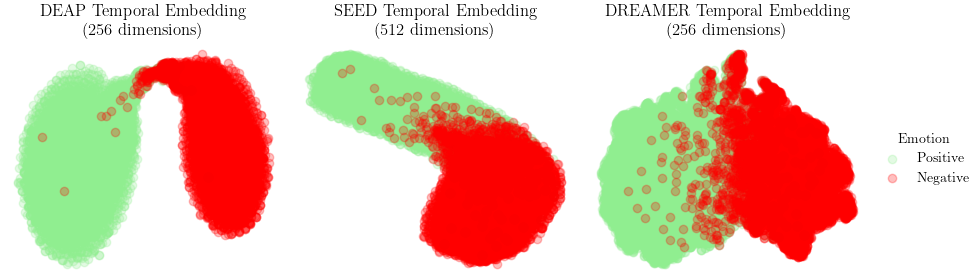

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

for i, dataset in enumerate(datasets):
    embedding_2d = temporal_tsne_results[dataset]
    labels = labels_dict[dataset]
    
    # Separate points by label
    positive_points = embedding_2d[labels == 1]
    negative_points = embedding_2d[labels == 0]
    
    # Plot
    plt.subplot(1, 3, i + 1)
    plt.scatter(positive_points[:, 0], positive_points[:, 1], c='lightgreen', alpha=0.25, label='Positive')
    plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', alpha=0.25, label='Negative')
    plt.title(f'{dataset} Temporal Embedding\n({temporal_embedding_representations[dataset].shape[-1]} dimensions)')
    plt.axis('off')

# Create a single legend for the entire figure
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"figures/embedding_temporal.png", dpi=300)
plt.show()

## Spatial Embedding Representation

In [15]:
import torch
from dataset import *

def load_grid_data(dataset_name):
    grid_datasets = prepare_dataset(feature_type='de_grid', class_type='binary', overlap_percent=0)
    grid_trainloaders, grid_valloaders, grid_testloaders = prepare_dataloaders(grid_datasets, 64, 0.2, SEED_NUMBER)
    
    deap, seed, dreamer = grid_testloaders
    
    if dataset_name == "DEAP":
        return deap
    elif dataset_name == "SEED":
        return seed
    elif dataset_name == "DREAMER":
        return dreamer

In [16]:
from pathlib import Path
from hydra import initialize, compose
from model import load_model

def load_server_model(base_path):
    # hydra configuration
    with initialize(config_path=str(Path(base_path) / ".hydra"), version_base=None):
        cfg = compose(config_name='config')
        
    # load the saved model state
    model_path = str(Path(base_path) / "model.pth")
    model_state = torch.load(model_path)
    model = load_model(cfg.model_type, cfg.seed)
    model.load_state_dict(model_state)
    
    return model

In [17]:
def get_feature_ccnn(model, data):
    # register forward hook
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    model.lin1.register_forward_hook(get_activation('lin1'))
    
    # feed-forward
    output = model(data)
    feature = activation['lin1']
    return feature.cpu().numpy()

In [18]:
datasets = ['DEAP', 'SEED', 'DREAMER']
spatial_embedding_representations = {}
labels_dict = {}

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
base_path = "multirun/server_side/ccnn_1/"

for dataset in datasets:
    data_loader = load_grid_data(dataset)
    model = load_server_model(base_path)
    model.to(device)
    
    embeddings_list = []
    labels_list = []
    
    for X, y in data_loader:
        embeddings = get_feature_ccnn(model, X)
        embeddings_list.append(embeddings)
        labels_list.append(y.numpy())
    
    # Concatenate all embeddings and labels for the dataset
    spatial_embedding_representations[dataset] = np.concatenate(embeddings_list, axis=0)
    labels_dict[dataset] = np.concatenate(labels_list, axis=0)

[2024-07-11 16:53:14] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_de_grid_0_percent_overlap.
[2024-07-11 16:53:14] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/seed_binary_de_grid_0_percent_overlap.
[2024-07-11 16:53:14] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/dreamer_de_grid_0_percent_overlap.
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
[2024-07-11 16:

In [19]:
from sklearn.manifold import TSNE

spatial_tsne_results = {}

for dataset in datasets:
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=SEED_NUMBER)
    embedding_2d = tsne.fit_transform(spatial_embedding_representations[dataset])
    
    # Save the t-SNE results
    spatial_tsne_results[dataset] = embedding_2d

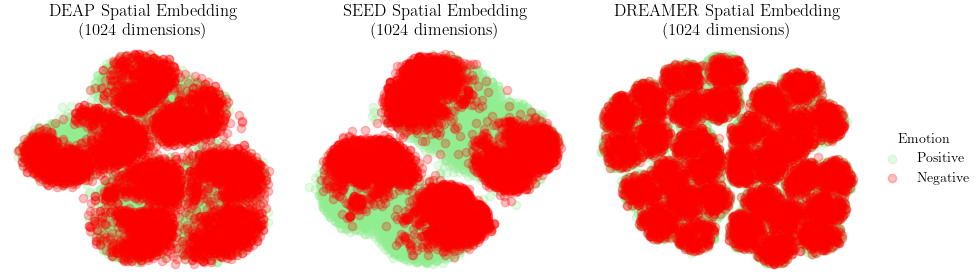

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

for i, dataset in enumerate(datasets):
    embedding_2d = spatial_tsne_results[dataset]
    labels = labels_dict[dataset]
    
    # Separate points by label
    positive_points = embedding_2d[labels == 1]
    negative_points = embedding_2d[labels == 0]
    
    # Plot
    plt.subplot(1, 3, i + 1)
    plt.scatter(positive_points[:, 0], positive_points[:, 1], c='lightgreen', alpha=0.25, label='Positive')
    plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', alpha=0.25, label='Negative')
    plt.title(f'{dataset} Spatial Embedding\n({spatial_embedding_representations[dataset].shape[-1]} dimensions)')
    plt.axis('off')

# Create a single legend for the entire figure
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"figures/embedding_spatial.png", dpi=300)
plt.show()

## Spatial + Temporal Embedding Representation

In [21]:
datasets = ['DEAP', 'SEED', 'DREAMER']
spatial_temporal_embedding_representations = {}
labels_dict = {}

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
base_path = "multirun/ccnn_1/ccnn_1_online_1_0.75"

for dataset in datasets:
    data_loader = load_grid_data(dataset)
    model = load_server_model(base_path)
    model.to(device)
    
    embeddings_list = []
    labels_list = []
    
    for X, y in data_loader:
        embeddings = get_feature_ccnn(model, X)
        embeddings_list.append(embeddings)
        labels_list.append(y.numpy())
    
    # Concatenate all embeddings and labels for the dataset
    spatial_temporal_embedding_representations[dataset] = np.concatenate(embeddings_list, axis=0)
    labels_dict[dataset] = np.concatenate(labels_list, axis=0)

[2024-07-11 16:55:35] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/deap_de_grid_0_percent_overlap.
[2024-07-11 16:55:36] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/seed_binary_de_grid_0_percent_overlap.
[2024-07-11 16:55:36] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../processed_data/dreamer_de_grid_0_percent_overlap.
/home/server-171/anaconda3/envs/eeg-gpu/lib/python3.9/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
[2024-07-11 16:

In [22]:
from sklearn.manifold import TSNE

spatial_temporal_tsne_results = {}

for dataset in datasets:
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=SEED_NUMBER)
    embedding_2d = tsne.fit_transform(spatial_temporal_embedding_representations[dataset])
    
    # Save the t-SNE results
    spatial_temporal_tsne_results[dataset] = embedding_2d

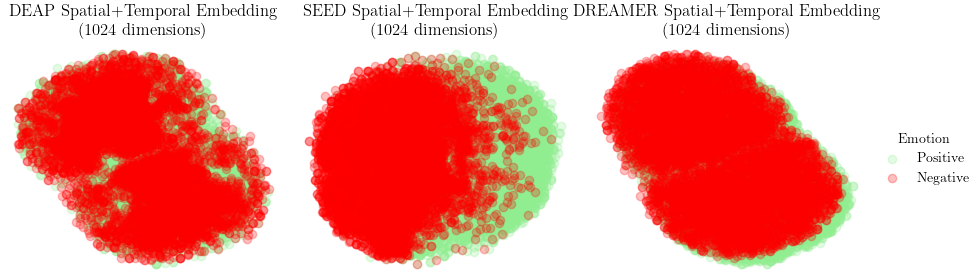

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

for i, dataset in enumerate(datasets):
    embedding_2d = spatial_temporal_tsne_results[dataset]
    labels = labels_dict[dataset]
    
    # Separate points by label
    positive_points = embedding_2d[labels == 1]
    negative_points = embedding_2d[labels == 0]
    
    # Plot
    plt.subplot(1, 3, i + 1)
    plt.scatter(positive_points[:, 0], positive_points[:, 1], c='lightgreen', alpha=0.25, label='Positive')
    plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', alpha=0.25, label='Negative')
    plt.title(f'{dataset} Spatial+Temporal Embedding\n({spatial_temporal_embedding_representations[dataset].shape[-1]} dimensions)')
    plt.axis('off')

# Create a single legend for the entire figure
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"figures/embedding_spatial_temporal.png", dpi=300)
plt.show()